In [1]:
import pandas as pd
import numpy as np
import os

## Load Data

In [2]:
train = np.load('train.npy',allow_pickle=True).item()
test = np.load('test-release.npy',allow_pickle=True).item()
sample_submission = np.load('sample-submission.npy',allow_pickle=True).item()

## Explore Data
Data is give in a series of "sequences", each sequence has a name and three columns.
The first column contains the annotations for each frame of the sequence.
The second column contains the keypoints, locations of key areas of both mice, as a series of embedded arrays.
The third column contains only the ID of the annotator who created the keypoints for the sequence.

In [3]:
print("Dataset keys - ", train.keys())
print("Vocabulary - ", train['vocabulary'])
print("Number of train Sequences - ", len(train['sequences']))
print("Number of test Sequences - ", len(test['sequences']))

Dataset keys -  dict_keys(['vocabulary', 'sequences'])
Vocabulary -  {'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
Number of train Sequences -  70
Number of test Sequences -  458


In [4]:
sequence_names = list(train["sequences"].keys())
sequence_key = sequence_names[0]
single_sequence = train["sequences"][sequence_key]
print("Sequence name - ", sequence_key)
print("Single Sequence keys", single_sequence.keys())
print(f"Number of Frames in {sequence_key} - ", len(single_sequence['annotations']))
print(f"Keypoints data shape of {sequence_key} - ", single_sequence['keypoints'].shape)
print(f"annotator_id of {sequence_key} - ", single_sequence['annotator_id'])

Sequence name -  1cac195d39
Single Sequence keys dict_keys(['keypoints', 'annotator_id', 'annotations'])
Number of Frames in 1cac195d39 -  4879
Keypoints data shape of 1cac195d39 -  (4879, 2, 2, 7)
annotator_id of 1cac195d39 -  0


In [5]:
train

{'vocabulary': {'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3},
 'sequences': {'1cac195d39': {'keypoints': array([[[[298.99367828, 266.99367828, 248.99367828, ..., 181.99367828,
             144.99367828, 125.99367828],
            [140.75094149, 194.75094149, 138.75094149, ..., 240.75094149,
             167.75094149, 241.75094149]],
   
           [[191.68942719, 226.68942719, 167.68942719, ..., 235.68942719,
             161.68942719, 203.68942719],
            [283.87298664, 323.87298664, 329.87298664, ..., 429.87298664,
             433.87298664, 487.87298664]]],
   
   
          [[[295.16745758, 272.16745758, 258.16745758, ..., 188.16745758,
             155.16745758, 132.16745758],
            [139.06031969, 185.06031969, 133.06031969, ..., 231.06031969,
             161.06031969, 235.06031969]],
   
           [[191.57169189, 224.57169189, 164.57169189, ..., 233.57169189,
             159.57169189, 202.57169189],
            [276.83287743, 321.83287743, 326.83287743,

## Visualise Data

In [6]:
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colors
from matplotlib import rc

rc('animation', html='jshtml')

# Note: Image processing may be slow if too many frames are animated.                

#Plotting constants
FRAME_WIDTH_TOP = 1024
FRAME_HEIGHT_TOP = 570

RESIDENT_COLOR = 'lawngreen'
INTRUDER_COLOR = 'skyblue'

PLOT_MOUSE_START_END = [(0, 1), (0, 2), (1, 3), (2, 3), (3, 4),
                        (3, 5), (4, 6), (5, 6), (1, 2)]

class_to_color = {'other': 'white', 'attack' : 'red', 'mount' : 'green',
                  'investigation': 'orange'}

class_to_number = {s: i for i, s in enumerate(train['vocabulary'])}

number_to_class = {i: s for i, s in enumerate(train['vocabulary'])}

def num_to_text(anno_list):
    return np.vectorize(number_to_class.get)(anno_list)

def set_figax():
    fig = plt.figure(figsize=(6, 4))

    img = np.zeros((FRAME_HEIGHT_TOP, FRAME_WIDTH_TOP, 3))

    ax = fig.add_subplot(111)
    ax.imshow(img)

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    return fig, ax

def plot_mouse(ax, pose, color):
    # Draw each keypoint
    for j in range(7):
        ax.plot(pose[j, 0], pose[j, 1], 'o', color=color, markersize=5)

    # Draw a line for each point pair to form the shape of the mouse

    for pair in PLOT_MOUSE_START_END:
        line_to_plot = pose[pair, :]
        ax.plot(line_to_plot[:, 0], line_to_plot[
                :, 1], color=color, linewidth=1)

def animate_pose_sequence(video_name, keypoint_sequence, start_frame = 0, stop_frame = 100, 
                          annotation_sequence = None):
    # Returns the animation of the keypoint sequence between start frame
    # and stop frame. Optionally can display annotations.
    seq = keypoint_sequence.transpose((0,1,3,2))

    image_list = []
    
    counter = 0
    for j in range(start_frame, stop_frame):
        if counter%20 == 0:
            print("Processing frame ", j)
        fig, ax = set_figax()
        plot_mouse(ax, seq[j, 0, :, :], color=RESIDENT_COLOR)
        plot_mouse(ax, seq[j, 1, :, :], color=INTRUDER_COLOR)
        
        if annotation_sequence is not None:
            annot = annotation_sequence[j]
            annot = number_to_class[annot]
            plt.text(50, -20, annot, fontsize = 16, 
                   bbox=dict(facecolor=class_to_color[annot], alpha=0.5))

        ax.set_title(
            video_name + '\n frame {:03d}.png'.format(j))

        ax.axis('off')
        fig.tight_layout(pad=0)
        ax.margins(0)

        fig.canvas.draw()
        image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(),
                                        dtype=np.uint8)
        image_from_plot = image_from_plot.reshape(
            fig.canvas.get_width_height()[::-1] + (3,)) 

        image_list.append(image_from_plot)

        plt.close()
        counter = counter + 1

    # Plot animation.
    fig = plt.figure()
    plt.axis('off')
    im = plt.imshow(image_list[0])

    def animate(k):
        im.set_array(image_list[k])
        return im,
    ani = animation.FuncAnimation(fig, animate, frames=len(image_list), blit=True)
    return ani

def plot_annotation_strip(annotation_sequence, start_frame = 0, stop_frame = 100, title="Behavior Labels"):
  # Plot annotations as a annotation strip.

  # Map annotations to a number.
    annotation_num = []
    for item in annotation_sequence[start_frame:stop_frame]:
        annotation_num.append(class_to_number[item])

    all_classes = list(set(annotation_sequence[start_frame:stop_frame]))

    cmap = colors.ListedColormap(['red', 'orange', 'green', 'white'])
    bounds=[-0.5,0.5,1.5, 2.5, 3.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    height = 200
    arr_to_plot = np.repeat(np.array(annotation_num)[:,np.newaxis].transpose(),
                                                  height, axis = 0)
  
    fig, ax = plt.subplots(figsize = (16, 3))
    ax.imshow(arr_to_plot, interpolation = 'none',cmap=cmap, norm=norm)

    ax.set_yticks([])
    ax.set_xlabel('Frame Number')
    plt.title(title)

    import matplotlib.patches as mpatches

    legend_patches = []
    for item in all_classes:
        legend_patches.append(mpatches.Patch(color=class_to_color[item], label=item))

    plt.legend(handles=legend_patches,loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()

Processing frame  3000
Processing frame  3020
Processing frame  3040
Processing frame  3060
Processing frame  3080


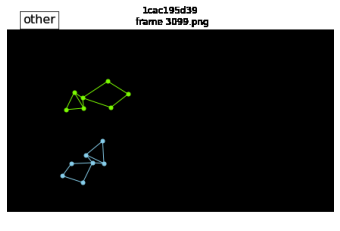

In [9]:
# Sample visualization for plotting pose gifs.

keypoint_sequence = single_sequence['keypoints']
annotation_sequence = single_sequence['annotations']

ani = animate_pose_sequence(sequence_key,
                            keypoint_sequence, 
                            start_frame = 3000,
                            stop_frame = 3100,
                            annotation_sequence = annotation_sequence)

# Display the animaion on colab
ani

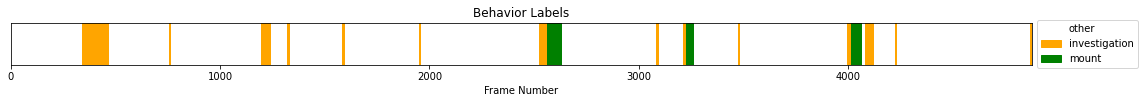

In [7]:
# Showing a section of the validation data (Index needs to be selected for a full video)
annotation_sequence = single_sequence['annotations']
text_sequence = num_to_text(annotation_sequence)
plot_annotation_strip(text_sequence,
                      start_frame = 0,
                      stop_frame = len(annotation_sequence) + 1000)

In [8]:
train["sequences"]

{'1cac195d39': {'keypoints': array([[[[298.99367828, 266.99367828, 248.99367828, ..., 181.99367828,
            144.99367828, 125.99367828],
           [140.75094149, 194.75094149, 138.75094149, ..., 240.75094149,
            167.75094149, 241.75094149]],
  
          [[191.68942719, 226.68942719, 167.68942719, ..., 235.68942719,
            161.68942719, 203.68942719],
           [283.87298664, 323.87298664, 329.87298664, ..., 429.87298664,
            433.87298664, 487.87298664]]],
  
  
         [[[295.16745758, 272.16745758, 258.16745758, ..., 188.16745758,
            155.16745758, 132.16745758],
           [139.06031969, 185.06031969, 133.06031969, ..., 231.06031969,
            161.06031969, 235.06031969]],
  
          [[191.57169189, 224.57169189, 164.57169189, ..., 233.57169189,
            159.57169189, 202.57169189],
           [276.83287743, 321.83287743, 326.83287743, ..., 429.83287743,
            433.83287743, 488.83287743]]],
  
  
         [[[301.36091766, 278.3609176

In [9]:
len(train["sequences"]['1cac195d39']['keypoints'])

4879

## Clean
Splits keypoints and annotations into two different collections. Drops annotator id because it is not nessecary for my calculations.

In [10]:
X_Collection = []
Y_Collection = []
for a in train["sequences"]:
    print(len(train["sequences"][a]["keypoints"]))
    X_Collection.append(train["sequences"][a]["keypoints"])
    Y_Collection.append(train["sequences"][a]["annotations"])

4879
1838
3996
4461
2713
17472
4260
10025
11431
13170
5495
5133
11322
2263
5641
3041
2751
17326
1440
3188
18617
7406
13222
5096
2885
1987
8103
6200
21364
974
17637
7024
8332
2497
3770
17946
3394
9838
3029
8666
9792
1062
6127
4755
7433
7190
1283
5065
1036
7754
3714
96
18423
3632
1213
1607
7150
16420
2796
2643
19343
8994
12537
11407
7410
8899
5763
3692
17319
3351


In [11]:
print(X_Collection[0][0])

[[[298.99367828 266.99367828 248.99367828 243.99367828 181.99367828
   144.99367828 125.99367828]
  [140.75094149 194.75094149 138.75094149 169.75094149 240.75094149
   167.75094149 241.75094149]]

 [[191.68942719 226.68942719 167.68942719 200.68942719 235.68942719
   161.68942719 203.68942719]
  [283.87298664 323.87298664 329.87298664 342.87298664 429.87298664
   433.87298664 487.87298664]]]


In [12]:
print(len(X_Collection[0][0]))
print(len(Y_Collection[0]))

2
4879


### Create Model

In [11]:
from tensorflow import keras

In [12]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model.add(keras.layers.Dense(100, activation="elu",
                             kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(100, activation="elu",
                             kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(100, activation="elu",
                             kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [13]:
optimizer = keras.optimizers.Nadam(lr=5e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

## Preproccess
### Split Data
Splitting uses the collections created during data cleaning, fed through the standard sklearn train_test_split function with a test size of 0.2

In [14]:
from sklearn.ensemble import RandomForestClassifier


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_Collection, Y_Collection, test_size=0.2, random_state=0)


In [18]:
print(X_train[0][0][0])

[[672.48378296 728.48378296 737.48378296 747.48378296 798.48378296
  835.48378296 860.48378296]
 [456.83829027 418.83829027 476.83829027 439.83829027 360.83829027
  428.83829027 365.83829027]]


In [19]:
y_train[0][0]

1

In [20]:
print(X_train[0])

[[[[672.48378296 728.48378296 737.48378296 ... 798.48378296
    835.48378296 860.48378296]
   [456.83829027 418.83829027 476.83829027 ... 360.83829027
    428.83829027 365.83829027]]

  [[689.25894165 734.25894165 673.25894165 ... 721.25894165
    652.25894165 668.25894165]
   [275.57452363 306.57452363 317.57452363 ... 396.57452363
    379.57452363 438.57452363]]]


 [[[673.92072754 728.92072754 733.92072754 ... 788.92072754
    824.92072754 853.92072754]
   [457.97056168 422.97056168 478.97056168 ... 370.97056168
    432.97056168 366.97056168]]

  [[665.35778809 718.35778809 662.35778809 ... 725.35778809
    655.35778809 668.35778809]
   [269.42776838 297.42776838 317.42776838 ... 388.42776838
    380.42776838 433.42776838]]]


 [[[671.37929077 721.37929077 737.37929077 ... 783.37929077
    823.37929077 854.37929077]
   [470.21236944 428.21236944 482.21236944 ... 372.21236944
    431.21236944 366.21236944]]

  [[647.77359009 703.77359009 650.77359009 ... 721.77359009
    649.77359009

In [21]:
def build_data(col):
    return_array = col[0:-1]
    return return_array

In [22]:
final_x_train = build_data(X_train[0])
final_x_test = build_data(X_test[0])

In [23]:
for a in final_x_test:
    print(a)

[[[738.07294922 685.07294922 696.07294922 673.07294922 568.07294922
   581.07294922 524.07294922]
  [427.64742714 449.64742714 399.64742714 422.64742714 436.64742714
   365.64742714 377.64742714]]

 [[522.84028625 475.84028625 462.84028625 453.84028625 424.84028625
   408.84028625 396.84028625]
  [407.41142321 452.41142321 385.41142321 422.41142321 452.41142321
   390.41142321 441.41142321]]]
[[[753.03372498 704.03372498 696.03372498 685.03372498 579.03372498
   592.03372498 531.03372498]
  [415.37246442 448.37246442 391.37246442 422.37246442 443.37246442
   372.37246442 384.37246442]]

 [[528.07436829 475.07436829 465.07436829 456.07436829 421.07436829
   408.07436829 399.07436829]
  [408.44503689 451.44503689 387.44503689 421.44503689 451.44503689
   393.44503689 427.44503689]]]
[[[767.19284363 712.19284363 706.19284363 698.19284363 583.19284363
   600.19284363 539.19284363]
  [404.39762861 443.39762861 388.39762861 418.39762861 446.39762861
   373.39762861 390.39762861]]

 [[526.129

[[[192.04983826 141.04983826 189.04983826 156.04983826  91.04983826
   166.04983826 120.04983826]
  [340.94282067 322.94282067 287.94282067 289.94282067 227.94282067
   209.94282067 162.94282067]]

 [[861.16449585 812.16449585 838.16449585 806.16449585 705.16449585
   704.16449585 654.16449585]
  [470.09096169 468.09096169 423.09096169 437.09096169 455.09096169
   393.09096169 430.09096169]]]
[[[193.51431427 141.51431427 187.51431427 156.51431427  92.51431427
   166.51431427 119.51431427]
  [340.99403831 323.99403831 291.99403831 292.99403831 230.99403831
   212.99403831 165.99403831]]

 [[859.19989014 814.19989014 838.19989014 809.19989014 706.19989014
   706.19989014 657.19989014]
  [473.72303963 470.72303963 425.72303963 437.72303963 454.72303963
   393.72303963 430.72303963]]]
[[[193.51193542 141.51193542 186.51193542 155.51193542  89.51193542
   165.51193542 116.51193542]
  [343.58389854 327.58389854 292.58389854 296.58389854 235.58389854
   215.58389854 171.58389854]]

 [[859.888

   238.44189429 240.44189429]]]
[[[560.85770569 528.85770569 579.85770569 555.85770569 547.85770569
   623.85770569 642.85770569]
  [254.1913231  203.1913231  200.1913231  191.1913231  113.1913231
   142.1913231  101.1913231 ]]

 [[626.62497559 678.62497559 633.62497559 664.62497559 684.62497559
   629.62497559 687.62497559]
  [164.44590208 205.44590208 238.44590208 231.44590208 201.44590208
   243.44590208 242.44590208]]]
[[[573.42385254 525.42385254 577.42385254 551.42385254 537.42385254
   617.42385254 632.42385254]
  [255.41865338 208.41865338 200.41865338 193.41865338 117.41865338
   141.41865338  98.41865338]]

 [[625.7213501  678.7213501  635.7213501  664.7213501  680.7213501
   631.7213501  687.7213501 ]
  [167.42793673 206.42793673 240.42793673 233.42793673 204.42793673
   245.42793673 246.42793673]]]
[[[581.85514221 528.85514221 579.85514221 554.85514221 534.85514221
   612.85514221 628.85514221]
  [256.52259201 210.52259201 200.52259201 193.52259201 120.52259201
   144.52259

   347.58964372 294.58964372]]]
[[[804.01140137 771.01140137 833.01140137 800.01140137 714.01140137
   734.01140137 668.01140137]
  [274.57977542 241.57977542 225.57977542 220.57977542 192.57977542
   126.57977542 148.57977542]]

 [[488.42718201 496.42718201 543.42718201 531.42718201 554.42718201
   609.42718201 605.42718201]
  [457.62865129 405.62865129 441.62865129 409.62865129 315.62865129
   348.62865129 295.62865129]]]
[[[797.54901123 769.54901123 824.54901123 796.54901123 715.54901123
   756.54901123 670.54901123]
  [282.70011362 244.70011362 233.70011362 222.70011362 182.70011362
   133.70011362 137.70011362]]

 [[491.28119812 496.28119812 542.28119812 530.28119812 551.28119812
   608.28119812 604.28119812]
  [462.34334961 409.34334961 445.34334961 413.34334961 316.34334961
   349.34334961 295.34334961]]]
[[[786.66887207 768.66887207 823.66887207 794.66887207 718.66887207
   760.66887207 681.66887207]
  [285.67224166 246.67224166 243.67224166 230.67224166 183.67224166
   132.672

   415.00417161 380.00417161]]]
[[[600.60388794 655.60388794 635.60388794 660.60388794 728.60388794
   708.60388794 767.60388794]
  [171.15114346 163.15114346 214.15114346 190.15114346 161.15114346
   237.15114346 226.15114346]]

 [[531.28699341 467.28699341 520.28699341 488.28699341 455.28699341
   529.28699341 519.28699341]
  [523.35746717 494.35746717 467.35746717 466.35746717 408.35746717
   415.35746717 380.35746717]]]
[[[602.49891357 659.49891357 638.49891357 662.49891357 728.49891357
   709.49891357 764.49891357]
  [169.66783838 161.66783838 216.66783838 190.66783838 161.66783838
   235.66783838 225.66783838]]

 [[529.88848877 466.88848877 519.88848877 486.88848877 455.88848877
   528.88848877 519.88848877]
  [522.61783826 492.61783826 466.61783826 465.61783826 405.61783826
   413.61783826 380.61783826]]]
[[[604.63580322 659.63580322 636.63580322 663.63580322 728.63580322
   714.63580322 763.63580322]
  [180.3946096  163.3946096  220.3946096  192.3946096  162.3946096
   233.3946

   219.5231387  171.5231387 ]]]
[[[560.63518677 609.63518677 580.63518677 612.63518677 692.63518677
   652.63518677 720.63518677]
  [350.28054655 334.28054655 393.28054655 370.28054655 370.28054655
   437.28054655 440.28054655]]

 [[163.03078613 126.03078613 182.03078613 158.03078613 177.03078613
   224.03078613 236.03078613]
  [317.57530081 279.57530081 280.57530081 264.57530081 181.57530081
   218.57530081 170.57530081]]]
[[[560.2130249  609.2130249  580.2130249  612.2130249  691.2130249
   651.2130249  720.2130249 ]
  [350.13472396 335.13472396 395.13472396 371.13472396 369.13472396
   437.13472396 440.13472396]]

 [[172.31881866 133.31881866 186.31881866 163.31881866 175.31881866
   224.31881866 232.31881866]
  [319.69178882 284.69178882 280.69178882 265.69178882 183.69178882
   218.69178882 169.69178882]]]
[[[559.44942932 608.44942932 582.44942932 611.44942932 690.44942932
   650.44942932 719.44942932]
  [349.6928429  333.6928429  392.6928429  370.6928429  367.6928429
   436.69284

   141.66451046 153.66451046]]]
[[[331.40901184 357.40901184 311.40901184 335.40901184 408.40901184
   362.40901184 445.40901184]
  [343.22464335 383.22464335 392.22464335 403.22464335 432.22464335
   487.22464335 484.22464335]]

 [[736.25757446 695.25757446 697.25757446 678.25757446 565.25757446
   583.25757446 531.25757446]
  [197.36043566 222.36043566 163.36043566 188.36043566 193.36043566
   140.36043566 155.36043566]]]
[[[335.1452179  363.1452179  310.1452179  335.1452179  408.1452179
   360.1452179  441.1452179 ]
  [342.3027885  379.3027885  388.3027885  398.3027885  430.3027885
   495.3027885  484.3027885 ]]

 [[742.15274353 697.15274353 706.15274353 680.15274353 566.15274353
   583.15274353 536.15274353]
  [194.39432579 216.39432579 161.39432579 185.39432579 194.39432579
   137.39432579 155.39432579]]]
[[[323.59823608 359.59823608 307.59823608 333.59823608 405.59823608
   357.59823608 439.59823608]
  [343.4890151  369.4890151  375.4890151  390.4890151  428.4890151
   491.489015

   367.89685786 300.89685786]]]
[[[282.29842682 229.29842682 229.29842682 215.29842682 163.29842682
   148.29842682 105.29842682]
  [185.3260182  217.3260182  150.3260182  185.3260182  235.3260182
   153.3260182  219.3260182 ]]

 [[290.06506042 314.06506042 333.06506042 338.06506042 368.06506042
   416.06506042 408.06506042]
  [415.90403333 378.90403333 438.90403333 399.90403333 323.90403333
   369.90403333 303.90403333]]]
[[[281.60175781 227.60175781 227.60175781 214.60175781 164.60175781
   149.60175781 110.60175781]
  [185.74140413 217.74140413 154.74140413 185.74140413 231.74140413
   156.74140413 215.74140413]]

 [[286.87766876 311.87766876 331.87766876 339.87766876 371.87766876
   420.87766876 403.87766876]
  [414.65468442 375.65468442 431.65468442 395.65468442 320.65468442
   358.65468442 296.65468442]]]
[[[279.41299744 221.41299744 225.41299744 211.41299744 162.41299744
   146.41299744 112.41299744]
  [192.6638553  220.6638553  157.6638553  187.6638553  230.6638553
   156.66385

   262.77712232 265.77712232]]]
[[[914.9468689  845.9468689  861.9468689  838.9468689  763.9468689
   757.9468689  700.9468689 ]
  [408.75469118 415.75469118 353.75469118 377.75469118 400.75469118
   321.75469118 370.75469118]]

 [[889.23110962 858.23110962 908.23110962 883.23110962 818.23110962
   875.23110962 813.23110962]
  [236.67944223 187.67944223 209.67944223 198.67944223 225.67944223
   264.67944223 258.67944223]]]
[[[912.61847534 838.61847534 860.61847534 832.61847534 759.61847534
   753.61847534 700.61847534]
  [411.07686597 418.07686597 355.07686597 376.07686597 400.07686597
   323.07686597 371.07686597]]

 [[888.01766968 858.01766968 908.01766968 883.01766968 820.01766968
   877.01766968 828.01766968]
  [242.59603405 189.59603405 210.59603405 202.59603405 232.59603405
   265.59603405 258.59603405]]]
[[[912.01879272 837.01879272 859.01879272 832.01879272 762.01879272
   757.01879272 700.01879272]
  [413.42318696 416.42318696 352.42318696 375.42318696 400.42318696
   324.4231

   344.18129256 378.18129256]]]
[[[356.38310242 343.38310242 399.38310242 378.38310242 391.38310242
   459.38310242 472.38310242]
  [274.79912853 216.79912853 246.79912853 223.79912853 141.79912853
   190.79912853 140.79912853]]

 [[166.00250549 169.00250549 118.00250549 139.00250549 176.00250549
   113.00250549 163.00250549]
  [170.48510447 214.48510447 201.48510447 224.48510447 325.48510447
   331.48510447 370.48510447]]]
[[[362.61766968 349.61766968 403.61766968 382.61766968 391.61766968
   458.61766968 474.61766968]
  [274.9991326  218.9991326  245.9991326  222.9991326  143.9991326
   188.9991326  140.9991326 ]]

 [[178.96226501 172.96226501 124.96226501 142.96226501 172.96226501
   109.96226501 158.96226501]
  [162.43876556 209.43876556 194.43876556 218.43876556 312.43876556
   320.43876556 364.43876556]]]
[[[360.92423096 349.92423096 405.92423096 385.92423096 389.92423096
   459.92423096 474.92423096]
  [278.60430261 221.60430261 247.60430261 221.60430261 146.60430261
   184.6043

   127.1106157  148.1106157 ]]]
[[[809.72205811 762.72205811 808.72205811 778.72205811 721.72205811
   765.72205811 714.72205811]
  [437.58978379 416.58978379 377.58978379 389.58978379 392.58978379
   337.58978379 355.58978379]]

 [[427.25914307 385.25914307 431.25914307 398.25914307 319.25914307
   358.25914307 289.25914307]
  [252.90611976 226.90611976 197.90611976 197.90611976 178.90611976
   127.90611976 143.90611976]]]
[[[807.92021484 762.92021484 807.92021484 778.92021484 724.92021484
   753.92021484 701.92021484]
  [434.68673259 416.68673259 375.68673259 388.68673259 396.68673259
   342.68673259 367.68673259]]

 [[425.3804657  385.3804657  431.3804657  398.3804657  325.3804657
   369.3804657  296.3804657 ]
  [250.18832508 229.18832508 200.18832508 201.18832508 175.18832508
   129.18832508 136.18832508]]]
[[[815.75285034 767.75285034 811.75285034 780.75285034 722.75285034
   756.75285034 699.75285034]
  [435.37382948 417.37382948 376.37382948 390.37382948 399.37382948
   339.3738

   137.31913757 125.31913757]]]
[[[195.19392395 238.19392395 227.19392395 246.19392395 364.19392395
   343.19392395 399.19392395]
  [270.02113003 258.02113003 304.02113003 283.02113003 286.02113003
   359.02113003 339.02113003]]

 [[451.46152344 471.46152344 516.46152344 501.46152344 474.46152344
   541.46152344 464.46152344]
  [266.76517841 208.76517841 240.76517841 212.76517841 156.76517841
   138.76517841 124.76517841]]]
[[[182.97834778 227.97834778 216.97834778 234.97834778 348.97834778
   325.97834778 388.97834778]
  [262.9258022  247.9258022  297.9258022  273.9258022  270.9258022
   344.9258022  325.9258022 ]]

 [[445.31948853 463.31948853 506.31948853 493.31948853 473.31948853
   543.31948853 466.31948853]
  [269.35211211 213.35211211 246.35211211 218.35211211 155.35211211
   147.35211211 125.35211211]]]
[[[172.611026   211.611026   204.611026   222.611026   329.611026
   302.611026   365.611026  ]
  [256.32419011 238.32419011 286.32419011 263.32419011 260.32419011
   323.324190

   129.41607669 138.41607669]]]
[[[259.45073242 242.45073242 312.45073242 279.45073242 262.45073242
   344.45073242 283.45073242]
  [435.36632225 363.36632225 381.36632225 362.36632225 300.36632225
   312.36632225 262.36632225]]

 [[746.69915771 719.69915771 766.69915771 738.69915771 665.69915771
   699.69915771 633.69915771]
  [263.07179543 227.07179543 215.07179543 207.07179543 177.07179543
   127.07179543 135.07179543]]]
[[[258.31092529 239.31092529 309.31092529 275.31092529 259.31092529
   344.31092529 284.31092529]
  [438.71487495 365.71487495 380.71487495 360.71487495 301.71487495
   310.71487495 259.71487495]]

 [[741.20822144 715.20822144 765.20822144 737.20822144 663.20822144
   706.20822144 640.20822144]
  [272.7400814  231.7400814  221.7400814  213.7400814  171.7400814
   127.7400814  130.7400814 ]]]
[[[256.5271286  238.5271286  307.5271286  276.5271286  261.5271286
   344.5271286  283.5271286 ]
  [441.45804787 375.45804787 382.45804787 363.45804787 301.45804787
   312.45804

   434.74282378 377.74282378]]]
[[[ 79.19662933 145.19662933 120.19662933 142.19662933 224.19662933
   188.19662933 264.19662933]
  [115.54494873 118.54494873 164.54494873 148.54494873 154.54494873
   215.54494873 223.54494873]]

 [[702.5407959  761.5407959  770.5407959  781.5407959  817.5407959
   872.5407959  844.5407959 ]
  [481.69760656 453.69760656 508.69760656 475.69760656 415.69760656
   440.69760656 384.69760656]]]
[[[ 99.25083771 149.25083771 123.25083771 148.25083771 227.25083771
   184.25083771 263.25083771]
  [121.74880639 120.74880639 168.74880639 149.74880639 155.74880639
   216.74880639 223.74880639]]

 [[694.00571289 750.00571289 764.00571289 774.00571289 816.00571289
   868.00571289 847.00571289]
  [489.73785043 457.73785043 511.73785043 479.73785043 418.73785043
   446.73785043 390.73785043]]]
[[[101.68579559 152.68579559 126.68579559 151.68579559 229.68579559
   186.68579559 264.68579559]
  [121.20574841 122.20574841 169.20574841 151.20574841 157.20574841
   218.2057

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [24]:
loop = 0
temp = []
for i in X_train[0]:
    temp.append(i)
    if loop == 0:
        print(i)
    loop += 1


[[[672.48378296 728.48378296 737.48378296 747.48378296 798.48378296
   835.48378296 860.48378296]
  [456.83829027 418.83829027 476.83829027 439.83829027 360.83829027
   428.83829027 365.83829027]]

 [[689.25894165 734.25894165 673.25894165 702.25894165 721.25894165
   652.25894165 668.25894165]
  [275.57452363 306.57452363 317.57452363 329.57452363 396.57452363
   379.57452363 438.57452363]]]


In [26]:
temp = X_train[0][0]
temp2 = X_test[0][0]
print(temp)

[[[672.48378296 728.48378296 737.48378296 747.48378296 798.48378296
   835.48378296 860.48378296]
  [456.83829027 418.83829027 476.83829027 439.83829027 360.83829027
   428.83829027 365.83829027]]

 [[689.25894165 734.25894165 673.25894165 702.25894165 721.25894165
   652.25894165 668.25894165]
  [275.57452363 306.57452363 317.57452363 329.57452363 396.57452363
   379.57452363 438.57452363]]]


In [67]:
print(temp)

[[[672.48378296 728.48378296 737.48378296 747.48378296 798.48378296
   835.48378296 860.48378296]
  [456.83829027 418.83829027 476.83829027 439.83829027 360.83829027
   428.83829027 365.83829027]]

 [[689.25894165 734.25894165 673.25894165 702.25894165 721.25894165
   652.25894165 668.25894165]
  [275.57452363 306.57452363 317.57452363 329.57452363 396.57452363
   379.57452363 438.57452363]]]


In [27]:
nsamples, nx, ny = temp.shape
X_temp = temp.reshape((nsamples, nx*ny))
print(X_temp)

[[672.48378296 728.48378296 737.48378296 747.48378296 798.48378296
  835.48378296 860.48378296 456.83829027 418.83829027 476.83829027
  439.83829027 360.83829027 428.83829027 365.83829027]
 [689.25894165 734.25894165 673.25894165 702.25894165 721.25894165
  652.25894165 668.25894165 275.57452363 306.57452363 317.57452363
  329.57452363 396.57452363 379.57452363 438.57452363]]


In [163]:
nsamples, nx, ny = temp2.shape
X_temp2 = temp2.reshape((nsamples, nx*ny))
print(X_temp2)

[[738.07294922 685.07294922 696.07294922 673.07294922 568.07294922
  581.07294922 524.07294922 427.64742714 449.64742714 399.64742714
  422.64742714 436.64742714 365.64742714 377.64742714]
 [522.84028625 475.84028625 462.84028625 453.84028625 424.84028625
  408.84028625 396.84028625 407.41142321 452.41142321 385.41142321
  422.41142321 452.41142321 390.41142321 441.41142321]]


In [28]:
def reshape_data(data):
    temp = []
    for a in data:
            nsamples, nx, ny = a.shape
            data_temp = a.reshape((nsamples, nx*ny))
            temp.append(data_temp)
    return np.array(temp)

In [29]:
datatemp = reshape_data(final_x_train)
datatemp2 = reshape_data(final_x_test)

In [30]:
print(datatemp[0])
print()
print(final_x_train[0])

[[672.48378296 728.48378296 737.48378296 747.48378296 798.48378296
  835.48378296 860.48378296 456.83829027 418.83829027 476.83829027
  439.83829027 360.83829027 428.83829027 365.83829027]
 [689.25894165 734.25894165 673.25894165 702.25894165 721.25894165
  652.25894165 668.25894165 275.57452363 306.57452363 317.57452363
  329.57452363 396.57452363 379.57452363 438.57452363]]

[[[672.48378296 728.48378296 737.48378296 747.48378296 798.48378296
   835.48378296 860.48378296]
  [456.83829027 418.83829027 476.83829027 439.83829027 360.83829027
   428.83829027 365.83829027]]

 [[689.25894165 734.25894165 673.25894165 702.25894165 721.25894165
   652.25894165 668.25894165]
  [275.57452363 306.57452363 317.57452363 329.57452363 396.57452363
   379.57452363 438.57452363]]]


In [31]:
nsamples, nx, ny = datatemp.shape
datatemp = datatemp.reshape((nsamples, nx*ny))
print(datatemp)

[[672.48378296 728.48378296 737.48378296 ... 396.57452363 379.57452363
  438.57452363]
 [673.92072754 728.92072754 733.92072754 ... 388.42776838 380.42776838
  433.42776838]
 [671.37929077 721.37929077 737.37929077 ... 388.25189602 384.25189602
  434.25189602]
 ...
 [674.01315918 643.01315918 619.01315918 ... 487.45020121 423.45020121
  460.45020121]
 [674.17227478 642.17227478 615.17227478 ... 487.78434867 423.78434867
  460.78434867]
 [673.29137573 641.29137573 618.29137573 ... 488.68130314 421.68130314
  461.68130314]]


In [32]:
nsamples, nx, ny = datatemp2.shape
datatemp2 = datatemp2.reshape((nsamples, nx*ny))
print(datatemp2)

[[738.07294922 685.07294922 696.07294922 ... 452.41142321 390.41142321
  441.41142321]
 [753.03372498 704.03372498 696.03372498 ... 451.44503689 393.44503689
  427.44503689]
 [767.19284363 712.19284363 706.19284363 ... 451.70088595 391.70088595
  391.70088595]
 ...
 [118.50677032 138.50677032 187.50677032 ... 206.22895631 139.22895631
  205.22895631]
 [118.11501007 141.11501007 188.11501007 ... 208.6241872  138.6241872
  206.6241872 ]
 [117.99677429 140.99677429 187.99677429 ... 208.29341556 139.29341556
  206.29341556]]


In [33]:
print(nsamples)
print(nx)
print(ny)

8102
2
14


In [34]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_passin = sc.fit_transform(datatemp)
X_test_passin = sc.transform(datatemp2)

In [35]:
print(y_train[0])
a = np.array(y_train[0][0:-1])
a
print(len(a))
print(len(X_train))

[1 1 1 ... 2 2 2]
2496
2496


## Fit and train the model

In [439]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def build_data(col):
    return_array = col[0:-1]
    return return_array

def reshape_data(data):
    temp = []
    for a in data:
            nsamples, nx, ny = a.shape
            data_temp = a.reshape((nsamples, nx*ny))
            temp.append(data_temp)
    return np.array(temp)

In [534]:
regressor = RandomForestClassifier(n_estimators=150, random_state=1, max_depth=40, min_samples_split=5)


In [535]:
X_train, X_test, y_train, y_test = train_test_split(X_Collection, Y_Collection, test_size=0.2, random_state=0)
sc = StandardScaler()

num_iteration = 0
for data_set in X_train:
    final_x_train = build_data(data_set)
    datatemp = reshape_data(final_x_train)
    nsamples, nx, ny = datatemp.shape
    datatemp = datatemp.reshape((nsamples, nx*ny))
    # X_train = sc.fit_transform(datatemp)
    X_train = datatemp
    a = np.array(y_train[num_iteration][1:])
    regressor.fit(X_train, a)
    num_iteration += 1
    


In [536]:
final_x_test = build_data(X_test[0])
datatemp = reshape_data(final_x_test)
nsamples, nx, ny = datatemp.shape
datatemp = datatemp.reshape((nsamples, nx*ny))
# X_test = sc.transform(datatemp)
X_test = datatemp

In [537]:
y_pred = regressor.predict(X_test)

In [538]:
y_pred

array([3, 3, 3, ..., 3, 3, 3])

In [539]:
yt = y_test[0]

In [540]:
print(len(y_pred))
print(len(y_test[0]))

8102
8103


In [541]:
yt = yt[0:-1]

In [542]:
numright = 0
for i in range(len(yt)):
    print("Pedicted Value:", end=" ")
    print(y_pred[i])
    print("Test_Value:", end=" ")
    print(yt[i])
    if y_pred[i] == yt[i]:
        numright += 1
print(numright)
print(len(y_pred) - numright)

Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted

Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted

Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted

Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Val

Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Val

Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted

Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 1
Pedicted Value: 1
Test_Value: 1
Pedicted Value: 1
Test_Value: 1
Pedicted Value: 1
Test_Value: 1
Pedicted Value: 1
Test_Value: 1
Pedicted Value: 1
Test_Value: 1
Pedicted Value: 1
Test_Value: 1
Pedicted Value: 1
Test_Value: 1
Pedicted Value: 1
Test_Value: 1
Pedicted Value: 1
Test_Value: 1
Pedicted Value: 1
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 1
Test_Value: 1
Pedicted Value: 1
Test_Value: 1
Pedicted Value: 1
Test_Value: 1
Pedicted Value: 1
Test_Value: 1
Pedicted Value: 1
Test_Value: 1
Pedicted Value: 1
Test_Val

Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 1
Pedicted Value: 1
Test_Value: 1
Pedicted Value: 1
Test_Value: 1
Pedicted Value: 1
Test_Value: 1
Pedicted Value: 1
Test_Value: 1
Pedicted Value: 1
Test_Value: 1
Pedicted Value: 1
Test_Value: 1
Pedicted Value: 1
Test_Value: 1
Pedicted Value: 1
Test_Value: 1
Pedicted Value: 1
Test_Value: 1
Pedicted Value: 1
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Val

Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted

Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Val

Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted

Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Val

Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted

In [543]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [544]:
print(classification_report(yt, y_pred))

              precision    recall  f1-score   support

           1       0.45      0.17      0.25      1329
           2       0.00      0.00      0.00         0
           3       0.89      0.95      0.92      6773

    accuracy                           0.82      8102
   macro avg       0.45      0.37      0.39      8102
weighted avg       0.82      0.82      0.81      8102



/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [545]:
print(accuracy_score(yt, y_pred))

0.8225129597630215


In [546]:
print(confusion_matrix(yt, y_pred))

[[ 226  316  787]
 [   0    0    0]
 [ 271   64 6438]]


In [547]:
print(classification_report(yt, y_pred))

              precision    recall  f1-score   support

           1       0.45      0.17      0.25      1329
           2       0.00      0.00      0.00         0
           3       0.89      0.95      0.92      6773

    accuracy                           0.82      8102
   macro avg       0.45      0.37      0.39      8102
weighted avg       0.82      0.82      0.81      8102



In [470]:
print(accuracy_score(yt, y_pred))

0.8228832387064923


In [471]:
print(confusion_matrix(yt, y_pred))

[[ 228  315  786]
 [   0    0    0]
 [ 269   65 6439]]


## New Model

In [169]:
from sklearn import tree

In [429]:
clf = tree.DecisionTreeClassifier(min_samples_split=2, min_samples_leaf=4, random_state=1)

In [430]:
X_train, X_test, y_train, y_test = train_test_split(X_Collection, Y_Collection, test_size=0.2, random_state=0)


num_iteration = 0
for data_set in X_train:
    final_x_train = build_data(data_set)
    datatemp = reshape_data(final_x_train)
    nsamples, nx, ny = datatemp.shape
    datatemp = datatemp.reshape((nsamples, nx*ny))
    X_train = sc.fit_transform(datatemp)
    # X_train = datatemp
    a = np.array(y_train[num_iteration][0:-1])
    clf.fit(X_train, a)
    num_iteration += 1

In [431]:
final_x_test = build_data(X_test[0])
datatemp = reshape_data(final_x_test)
nsamples, nx, ny = datatemp.shape
datatemp = datatemp.reshape((nsamples, nx*ny))
X_test = sc.transform(datatemp)
# X_test = datatemp

In [432]:
yt = y_test[0]

In [433]:
y_pred = clf.predict(X_test)

In [434]:
yt = yt[0:-1]

In [435]:
numright = 0
for i in range(len(yt)):
    print("Pedicted Value:", end=" ")
    print(y_pred[i])
    print("Test_Value:", end=" ")
    print(yt[i])
    if y_pred[i] == yt[i]:
        numright += 1
print(numright)
print(len(y_pred) - numright)

Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted

Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted

Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Val

Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted

Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Val

Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Val

Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Val

Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Val

Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted

Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 3
Pedicted Value: 1
Test_Value: 1
Pedicted Value: 1
Test_Value: 1
Pedicted Value: 1
Test_Value: 1
Pedicted Value: 1
Test_Value: 1
Pedicted Value: 1
Test_Value: 1
Pedicted Value: 1
Test_Value: 1
Pedicted Value: 1
Test_Value: 1
Pedicted Value: 1
Test_Value: 1
Pedicted Value: 1
Test_Value: 1
Pedicted Value: 1
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted Value: 3
Test_Value: 1
Pedicted

Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted

Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Value: 3
Pedicted Value: 3
Test_Val

In [436]:
print(classification_report(yt, y_pred))

              precision    recall  f1-score   support

           1       0.16      0.05      0.07      1329
           3       0.84      0.95      0.89      6773

    accuracy                           0.80      8102
   macro avg       0.50      0.50      0.48      8102
weighted avg       0.72      0.80      0.76      8102



In [437]:
print(accuracy_score(yt, y_pred))

0.8022710441866205
